In [15]:
# Build a Transformer architecture from scratch using only PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

In [16]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super().__init__()
    self.d_model = d_model    # embedding dimension (e.g., 512)
    self.num_heads = num_heads  # number of attention heads (e.g., 8)
    self.head_dim = d_model // num_heads  # dimension per head (e.g., 64)

    # Create the Q, K, V projection layers
    self.q_proj = nn.Linear(d_model, d_model)
    self.k_proj = nn.Linear(d_model, d_model)
    self.v_proj = nn.Linear(d_model, d_model)

    # Final output projection
    self.out_proj = nn.Linear(d_model, d_model)

  # scaled dot product attention
  def attention(self, Q, K, V, mask=None):
    """
    Q, K, V are expected to be of shape:
      [batch_size, seq_len, d_k]
    or possibly
      [batch_size, num_heads, seq_len, d_k]
    if you’re already doing multi-head splitting.
    """
    d_k = K.shape[-1]
    scores = Q @ K.transpose(-2, -1)
    scores = scores / math.sqrt(d_k)
    # Apply mask if provided
    if mask is not None:
        # Expand mask to match the batch size and number of heads
        # mask shape: [batch_size, 1, seq_len, seq_len] or [batch_size, 1, 1, seq_len]
        scores = scores.masked_fill(mask == 0, -1e9)

    attention_weights = F.softmax(scores, dim=-1)
    output = attention_weights @ V

    return output, attention_weights

  def transopse_akv(self, output, attention_weights, batch_size, seq_len, d_model):
    # re-order dimensions back to original
    output = torch.permute(output, (0, 2, 1, 3))
    # reshape the dimensions to "combine" the attention heads outputs
    output = output.reshape(batch_size, seq_len, d_model)
    # attention_weights has shape [batch_size, num_heads, seq_len, seq_len]
    # Average across the heads dimension (dim=1)
    attention_weights = attention_weights.mean(dim=1)

    return output, attention_weights

  def forward(self, q, k, v, mask=None):
    batch_size, seq_len, d_model = q.shape
    Q = self.q_proj(q)
    K = self.k_proj(k)
    V = self.v_proj(v)

    # Reshape to separate the heads
    Q = Q.view(batch_size, -1, self.num_heads, self.head_dim)
    K = K.view(batch_size, -1, self.num_heads, self.head_dim)
    V = V.view(batch_size, -1, self.num_heads, self.head_dim)

    # re-order dimensions to be compatible with attention method
    Q = torch.permute(Q, (0, 2, 1, 3))
    K = torch.permute(K, (0, 2, 1, 3))
    V = torch.permute(V, (0, 2, 1, 3))

    output, attention_weights = self.attention(Q, K, V, mask)
    output, attention_weights = self.transopse_akv(output, attention_weights, batch_size, seq_len, d_model)

    return self.out_proj(output)

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()

        # Multi-head attention
        self.self_attention = MultiHeadAttention(d_model, n_heads)

        # Feed forward
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

        # Normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Self attention
        attn_output = self.self_attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output)) # residual connection

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output)) # residual connection

        return x

class Encoder(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, num_layers, dropout=0.1):
      super(Encoder, self).__init__()

      # Stack of encoder layers
      self.layers = nn.ModuleList([
          EncoderLayer(d_model, n_heads, d_ff, dropout)
          for _ in range(num_layers)
      ])

  def forward(self, x, mask):
      for layer in self.layers:
          x = layer(x, mask)
      return x

In [18]:
class DecoderLayer(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
    super(DecoderLayer, self).__init__()
    # TODO: Initialize three components:
    # 1. Masked multi-head self-attention (for target sequence)
    self.self_attention = MultiHeadAttention(d_model, n_heads)

    # 2. Multi-head cross-attention (to attend to encoder outputs)
    self.cross_attention = MultiHeadAttention(d_model, n_heads)

    # 3. Feed-forward network
    self.feed_forward = nn.Sequential(
        nn.Linear(d_model, d_ff),
        nn.ReLU(),
        nn.Linear(d_ff, d_model)
    )
    # 4. Initialize normalization layers
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)  # One more for the cross-attention

    # 5. Initialize dropout
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, enc_output, src_mask, tgt_mask):
    # First sub-layer - masked self-attention on target sequence
    # Remember to apply residual connection and layer normalization
    attn_output = self.self_attention(x, x, x, tgt_mask)
    x = self.norm1(x + self.dropout(attn_output))

    # Second sub-layer - cross-attention with encoder outputs
    # Remember to apply residual connection and layer normalization
    cross_attn_output = self.cross_attention(x, enc_output, enc_output, src_mask)
    x = self.norm2(x + self.dropout(cross_attn_output)) # residual connection

    # Third sub-layer - feed-forward network
    # Remember to apply residual connection and layer normalization
    ff_output = self.feed_forward(x)
    x = self.norm3(x + self.dropout(ff_output)) # this is the residual connection

    return x

class Decoder(nn.Module):
  def __init__(self, d_model, n_heads, d_ff, num_layers, dropout=0.1):
    super(Decoder, self).__init__()

    # Stack of decoder layers
    self.layers = nn.ModuleList([
        DecoderLayer(d_model, n_heads, d_ff, dropout)
        for _ in range(num_layers)
    ])

  def forward(self, x, enc_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return x

In [19]:
class Transformer(nn.Module):
  def __init__(self,
              src_vocab_size,
              tgt_vocab_size,
              d_model, # embedding dimension
              num_heads,
              num_encoder_layers,
              num_decoder_layers,
              d_ff,
              max_seq_length,
              dropout=0.1):
      super(Transformer, self).__init__()
      self.d_model = d_model
      self.num_heads = num_heads
      # Create embedding layers
      self.src_embedding = nn.Embedding(src_vocab_size, d_model) # Question: Are source embeddings and target embeddings required here?
      self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
      # Add positional encoding
      self.positional_encoding = self.create_positional_encoding(max_seq_length, d_model)
      self.dropout = nn.Dropout(dropout)

      # Create encoder
      self.encoder = Encoder(d_model, num_heads, d_ff, num_encoder_layers, dropout)

      # Create decoder
      self.decoder = Decoder(d_model, num_heads, d_ff, num_decoder_layers, dropout)

      # Create final output layer
      self.output_layer = nn.Linear(d_model, tgt_vocab_size)

  def create_positional_encoding(self, max_seq_length, d_model):
    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)  # Add batch dimension

    # Register as buffer (not a parameter, but should be saved and moved with the model)
    return nn.Parameter(pe, requires_grad=False)

  def forward(self, src, tgt, src_mask, tgt_mask):
    # Get sequence lengths for positional encoding
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)

    # Embed source and add positional encoding
    src_embedded = self.dropout(self.src_embedding(src) * math.sqrt(self.d_model) + self.positional_encoding[:, :src_seq_len, :])

    # Pass through encoder
    enc_output = self.encoder(src_embedded, src_mask)

    # Embed target and add positional encoding
    tgt_embedded = self.dropout(self.tgt_embedding(tgt) * math.sqrt(self.d_model) + self.positional_encoding[:, :tgt_seq_len, :])

    # Pass through decoder (with encoder output)
    dec_output = self.decoder(tgt_embedded, enc_output, src_mask, tgt_mask)

    # Pass through final output layer and return raw logits
    logits = self.output_layer(dec_output)

    return logits

In [20]:
# Test parameters
batch_size = 2
seq_len = 10
d_model = 64
n_heads = 8
head_dim = d_model // n_heads

# Create test input
x = torch.randn(batch_size, seq_len, d_model)

# Create a mask (optional)
mask = torch.ones(batch_size, 1, seq_len, seq_len)
# Set some elements to 0 to test masking
mask[:, :, :, 5:] = 0

# Initialize the attention module
attention = MultiHeadAttention(d_model, n_heads)

# Forward pass
output = attention(x, x, x, mask)

# Check output shape
print(f"MultiHeadAttention output shape: {output.shape}")
print(f"Expected shape: {(batch_size, seq_len, d_model)}")
print(f"Test {'passed' if output.shape == (batch_size, seq_len, d_model) else 'failed'}")

MultiHeadAttention output shape: torch.Size([2, 10, 64])
Expected shape: (2, 10, 64)
Test passed


In [21]:
# Test EncoderLayer
enc_layer = EncoderLayer(d_model, n_heads, d_ff=256)

# Forward pass
enc_output = enc_layer(x, mask)

# Check output shape
print(f"EncoderLayer output shape: {enc_output.shape}")
print(f"Expected shape: {(batch_size, seq_len, d_model)}")
print(f"Test {'passed' if enc_output.shape == (batch_size, seq_len, d_model) else 'failed'}")

EncoderLayer output shape: torch.Size([2, 10, 64])
Expected shape: (2, 10, 64)
Test passed


In [22]:
# Test parameters
num_encoder_layers = 2

# Initialize the encoder
encoder = Encoder(d_model, n_heads, d_ff=256, num_layers=num_encoder_layers)

# Forward pass
enc_output = encoder(x, mask)

# Check output shape
print(f"Encoder output shape: {enc_output.shape}")
print(f"Expected shape: {(batch_size, seq_len, d_model)}")
print(f"Test {'passed' if enc_output.shape == (batch_size, seq_len, d_model) else 'failed'}")

Encoder output shape: torch.Size([2, 10, 64])
Expected shape: (2, 10, 64)
Test passed


In [23]:
# Create encoder output for cross-attention
enc_output = torch.randn(batch_size, seq_len, d_model)

# Create source and target masks
src_mask = torch.ones(batch_size, 1, 1, seq_len)
tgt_mask = torch.tril(torch.ones(batch_size, 1, seq_len, seq_len))

# Initialize the decoder layer
dec_layer = DecoderLayer(d_model, n_heads, d_ff=256)

# Forward pass
dec_output = dec_layer(x, enc_output, src_mask, tgt_mask)

# Check output shape
print(f"DecoderLayer output shape: {dec_output.shape}")
print(f"Expected shape: {(batch_size, seq_len, d_model)}")
print(f"Test {'passed' if dec_output.shape == (batch_size, seq_len, d_model) else 'failed'}")

DecoderLayer output shape: torch.Size([2, 10, 64])
Expected shape: (2, 10, 64)
Test passed


In [24]:
# Test parameters
num_decoder_layers = 2

# Initialize the decoder
decoder = Decoder(d_model, n_heads, d_ff=256, num_layers=num_decoder_layers)

# Forward pass
dec_output = decoder(x, enc_output, src_mask, tgt_mask)

# Check output shape
print(f"Decoder output shape: {dec_output.shape}")
print(f"Expected shape: {(batch_size, seq_len, d_model)}")
print(f"Test {'passed' if dec_output.shape == (batch_size, seq_len, d_model) else 'failed'}")

Decoder output shape: torch.Size([2, 10, 64])
Expected shape: (2, 10, 64)
Test passed


Positional Encoding shape: torch.Size([1, 100, 64])
Expected shape: (1, 100, 64)
Test passed


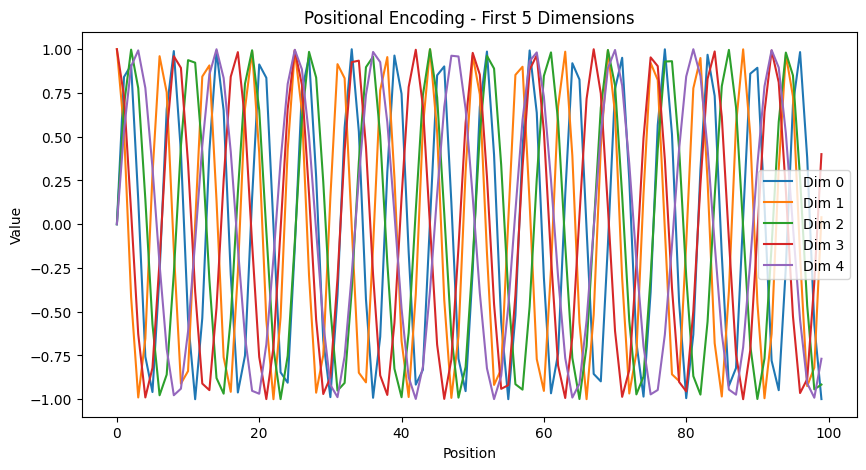

In [25]:
# Initialize model parameters
max_seq_length = 100

# Create positional encoding function
def create_positional_encoding(max_seq_length, d_model):
    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)  # Add batch dimension
    return pe

# Generate positional encoding
pos_encoding = create_positional_encoding(max_seq_length, d_model)

# Check shape
print(f"Positional Encoding shape: {pos_encoding.shape}")
print(f"Expected shape: {(1, max_seq_length, d_model)}")
print(f"Test {'passed' if pos_encoding.shape == (1, max_seq_length, d_model) else 'failed'}")

# Visualize a few dimensions to verify sinusoidal pattern
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(5):  # Plot first 5 dimensions
    plt.plot(pos_encoding[0, :, i].numpy())
plt.title("Positional Encoding - First 5 Dimensions")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend([f"Dim {i}" for i in range(5)])
plt.show()

In [26]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define test parameters
src_vocab_size = 1000
tgt_vocab_size = 1000
d_model = 64      # Smaller than standard for quick testing
n_heads = 8
num_encoder_layers = 2  # Fewer layers for quick testing
num_decoder_layers = 2  # Fewer layers for quick testing
d_ff = 256       # Smaller than standard for quick testing
max_seq_length = 50
batch_size = 4
src_seq_length = 10
tgt_seq_length = 12

# Initialize the model
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    num_heads=n_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    d_ff=d_ff,
    max_seq_length=max_seq_length
).to(device)

# Create dummy inputs
src = torch.randint(1, src_vocab_size, (batch_size, src_seq_length)).to(device)
tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_length)).to(device)

# Create masks
# Source mask: used to pad attention where source tokens are padding
src_mask = torch.ones(batch_size, 1, 1, src_seq_length).to(device)

# Target mask: combination of padding mask and subsequent mask
# Subsequent mask prevents attending to future tokens during training
tgt_mask = torch.tril(torch.ones(batch_size, 1, tgt_seq_length, tgt_seq_length)).to(device)

# Forward pass
with torch.no_grad():
    output = model(src, tgt, src_mask, tgt_mask)

# Print output shape
print(f"Output shape: {output.shape}")
expected_shape = (batch_size, tgt_seq_length, tgt_vocab_size)
print(f"Expected shape: {expected_shape}")
print(f"Test {'passed' if output.shape == expected_shape else 'failed'}")

# Check for any NaN values in the output
print(f"Contains NaN: {torch.isnan(output).any().item()}")

Using device: cuda
Output shape: torch.Size([4, 12, 1000])
Expected shape: (4, 12, 1000)
Test passed
Contains NaN: False
